In [ ]:
# Wiki data Preprocess:
#
# 1. Extract wiki data
#    $ python WikiExtractor.py -b 1024M -o extracted zhwiki-20181101-pages-articles.xml.bz2
#
# 2. Covert traditional chinese to simplified chinese
#    Using opencc
#    $ opencc -i wiki_00 -o zh_wiki_00 -c zht2zhs.ini
#    $ opencc -i wiki_01 -o zh_wiki_01 -c zht2zhs.ini
#
# 3. Replace special characters
#    import re
#    import sys
#    import codecs
#    def myfun(input_file):
#        p1 = re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
#        p2 = re.compile(r'[（\(][，；。？！\s]*[）\)]')
#        p3 = re.compile(r'[「『]')
#        p4 = re.compile(r'[」』]')
#        outfile = codecs.open('std_' + input_file, 'w', 'utf-8')
#        with codecs.open(input_file, 'r', 'utf-8') as myfile:
#            for line in myfile:
#                line = p1.sub(r'\2', line)
#                line = p2.sub(r'', line)
#                line = p3.sub(r'“', line)
#                line = p4.sub(r'”', line)
#                outfile.write(line)
#        outfile.close()
#    if __name__ == '__main__':
#        if len(sys.argv) != 2:
#            print("Usage: python script.py inputfile")
#            sys.exit()
#        input_file = sys.argv[1]
#        myfun(input_file)
#
# 4. Remove special lines start with '<', i.e. '<doc id****', '<\doc>'
#    import re
#    import codecs
#    import sys
#
#    r1 = re.compile(r'^<')
#
#    def pre(input_file):
#        outfile = codecs.open(input_file + '_pre', 'w', 'utf-8')
#        with codecs.open(input_file, 'r', 'utf-8') as myfile:
#            for line in myfile:
#                if re.match(r1, line):
#                    pass
#                else:
#                    outfile.write(line)
#        outfile.close()
#
#    if __name__ == '__main__':
#        if len(sys.argv) != 2:
#            sys.exit()
#
#        pre(sys.argv[1])

In [1]:
from collections import Counter
from matplotlib.pyplot import xscale, yscale, plot, title
from functools import reduce
import re
import time
import copy
import jieba

In [2]:
def tokenize(string):
    return ''.join(re.findall('[\w|\d]+', string))

In [3]:
def get_prob_from_counter(counter):
    all_occurs = sum(counter.values())

    def get_item_prob(item):
        return counter[item] / all_occurs

    return get_item_prob

In [4]:
def get_running_time(func, args, times):
    start_time = time.time()
    for i in range(times):
        func(args)
    print('{} elapsed time: {}'.format(func.__name__, (time.time() - start_time) / times))

In [5]:
def mult_func(a, b):
    return a * b

In [6]:
def get_string_probablity(func, string):
    return reduce(mult_func, [func(s) for s in string])

In [7]:
def get_probability_performance(prob_func, func, pairs):
    for (p1, p2) in pairs:
        print('{} with probablity: {}'.format(p1, prob_func(func, tokenize(p1))))
        print('{} with probablity: {}'.format(p2, prob_func(func, tokenize(p2))))
        print('')

In [8]:
# N-gram counter
def gen_n_gram_counter(string, gram_n=2):
    return Counter([''.join(string[i:i + gram_n]) for i in range(len(string) - gram_n + 1)])

In [9]:
# Good–Turing frequency estimation
def gen_gd_counter(counter):
    counter_counter = Counter([n for (w, n) in counter.items()])
    # deep copy
    new_counter = copy.deepcopy(counter)
    for (w, n) in counter.items():
        if n < 8:
            new_counter[w] = (n + 1) * counter_counter[n + 1] / counter_counter[n]
    return new_counter

In [10]:
def get_two_gram_gd_prob(counter1, counter2, pairs, content):
    counter1_gd = gen_gd_counter(counter1)
    counter2_gd = gen_gd_counter(counter2)

    get_uni_prob = get_prob_from_counter(counter1_gd)
    get_pair_prob = get_prob_from_counter(counter2_gd)

    # def get_2_gram_prob(word, prev):
    #     if get_pair_prob(prev + word) > 0:
    #         return get_pair_prob(prev + word) / get_uni_prob(prev)
    #     else:
    #         return get_uni_prob(word)
    #
    # def get_2_gram_string_prob(string):
    #     probablities = []
    #     for i, c in enumerate(string):
    #         prev = '<s>' if i == 0 else string[i - 1]
    #         probablities.append(get_2_gram_prob(c, prev))
    #     return reduce(mult_func, probablities)
    #
    # for (p1, p2) in pairs:
    #     print('{} with probablity: {}'.format(p1, get_2_gram_string_prob(tokenize(p1))))
    #     print('{} with probablity: {}'.format(p2, get_2_gram_string_prob(tokenize(p2))))
    #     print('')

    N_total = sum(counter2.values())
    N_seen = sum(counter2_gd.values())

    def get_prob(validate_str):
        probs = []
        unseens = []
        for i in range(1, len(validate_str)):
            cur = validate_str[i - 1:i + 1]
            if cur not in content:
                unseens.append(cur)
            else:
                prob = get_pair_prob(cur) / get_uni_prob(cur[0])
                probs.append(prob)

        print('probs 1: ', probs)

        unseens_counter = Counter(unseens)
        N_unseen = sum(unseens_counter.values())
        unseens_prob = 1 - N_seen / N_total

        for (w, c) in unseens_counter.items():
            probs.append(c * unseens_prob / N_unseen)

        print('probs 2: ', probs)

        ret = reduce(mult_func, probs)
        return ret

    for (p1, p2) in pairs:
        print('{} with probablity: {}'.format(p1, get_prob(tokenize(p1))))
        print('{} with probablity: {}'.format(p2, get_prob(tokenize(p2))))
        print('')

In [11]:
pair1 = """前天晚上吃晚饭的时候
前天晚上吃早饭的时候""".split('\n')

pair2 = """正是一个好看的小猫
真是一个好看的小猫""".split('\n')

pair3 = """我无言以对，简直
我简直无言以对东磁哇啦嚄""".split('\n')

pairs = [pair1, pair2, pair3]

In [13]:
filename = 'std_zh_wiki_01_pre'
with open(filename, encoding='utf-8') as f:
    all_content = f.read()

In [14]:
all_content = tokenize(all_content)

In [15]:
uni_gram_counter = Counter(all_content)

In [16]:
uni_gram_counter.most_common(10)

[('的', 1482263),
 ('1', 1061143),
 ('0', 786566),
 ('年', 725511),
 ('2', 681995),
 ('在', 493794),
 ('一', 468766),
 ('人', 455999),
 ('为', 449511),
 ('9', 445277)]

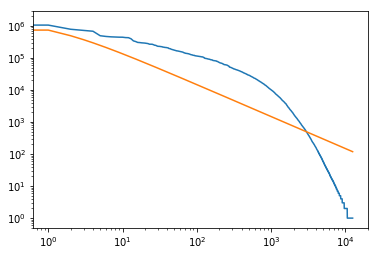

In [18]:
M = uni_gram_counter.most_common()[0][1]
len(uni_gram_counter)

xscale('log')
yscale('log')

plot([c for (w, c) in uni_gram_counter.most_common()])
plot([M / i for i in range(1, len(uni_gram_counter) + 1)])

In [19]:
get_item_prob = get_prob_from_counter(uni_gram_counter)

In [20]:
get_item_prob('的')

0.023896122094417847

In [21]:
get_running_time(get_item_prob, '的', 100000)

get_item_prob elapsed time: 2.4932384490966794e-07


In [22]:
get_string_probablity(get_item_prob, '你好吗')
get_string_probablity(get_item_prob, '你坏吗')

2.1028840323444115e-13

In [23]:
get_probability_performance(get_string_probablity, get_item_prob, pairs)

前天晚上吃晚饭的时候 with probablity: 8.269947669539467e-33
前天晚上吃早饭的时候 with probablity: 1.3028536227443667e-32

正是一个好看的小猫 with probablity: 2.550728876961171e-26
真是一个好看的小猫 with probablity: 7.251389832001185e-27

我无言以对，简直 with probablity: 9.706729497120774e-23
我简直无言以对东磁哇啦嚄 with probablity: 0.0



In [24]:
# 2-gram
two_gram_counter = gen_n_gram_counter(all_content)
print(two_gram_counter.most_common(10))
get_two_gram_gd_prob(uni_gram_counter, two_gram_counter, pairs, all_content)

[('20', 320660), ('19', 240998), ('01', 226603), ('00', 172892), ('年1', 96718), ('10', 94901), ('一个', 82197), ('18', 80999), ('位于', 80196), ('公里', 77125)]
probs 1:  [0.00048471609880093667, 0.0048014224284043065, 0.21617585047150678, 0.00011475021000232553, 0.0073663424563852236, 0.0024307629363362828, 0.02500032414718471, 0.005416394037261286, 0.025349403481688175]
probs 2:  [0.00048471609880093667, 0.0048014224284043065, 0.21617585047150678, 0.00011475021000232553, 0.0073663424563852236, 0.0024307629363362828, 0.02500032414718471, 0.005416394037261286, 0.025349403481688175]
前天晚上吃晚饭的时候 with probablity: 3.548429425045409e-21
probs 1:  [0.00048471609880093667, 0.0048014224284043065, 0.21617585047150678, 0.00011475021000232553, 0.005831687777971635, 0.00028546707279492094, 0.02500032414718471, 0.005416394037261286, 0.025349403481688175]
probs 2:  [0.00048471609880093667, 0.0048014224284043065, 0.21617585047150678, 0.00011475021000232553, 0.005831687777971635, 0.00028546707279492094, 0.02